In [1]:
from utils import *
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt

## Predicción usando TIFUKNN

Se implementarán el algoritmo TIFUKNN y , pues combina de forma adecuada la simplicidad con buena performance en los benchmark públicos según la literatura. El proceso es el siguiente:

0.- Transformo el dataset de transactions a pandas 

1.- Separo los datos en entrenamiento y test usando una separación temporal bi-semanal y dejando solo el último periodo para test y el resto de la historia para entrenar

2.- Similitud de coseno: calculamos la similitud de coseno entre artículos para identificar SKU similares.

3.- Predicción: el algoritmo TIFUKNN predice la próxima cesta en función de los artículos más similares a los del historial de compras del cliente.

4.- Evaluación: calculamos la precisión y la recuperación en K para medir qué tan bien el modelo predice la próxima cesta.

In [2]:
# Read the csv files of the atributes
file_path_atributes = "../data/processed/atributes.parquet"
atributes = pl.read_parquet(file_path_atributes)
# Read the csv files of the transactions
file_path_transactions = "../data/processed/transactions.parquet"
transactions = pl.read_parquet(file_path_transactions)
pd_transactions = transactions.to_pandas()
pd_transactions.sort_values(by=['account_id', 'invoice_date'])
pd_transactions.head()

,,account_id,sku_id,invoice_date,order_id,items_phys_cases
0,0,430606,7038,2022-07-29,512-3880249-0,100
1,1,323267,14933,2022-07-29,512-3882307-0,1
2,2,357825,21971,2022-07-23,512-3852880-0,8
3,3,444926,7038,2022-08-05,512-3913163-0,20
4,4,450771,7030,2022-08-16,512-3957000-0,5


86.94681442021451
5


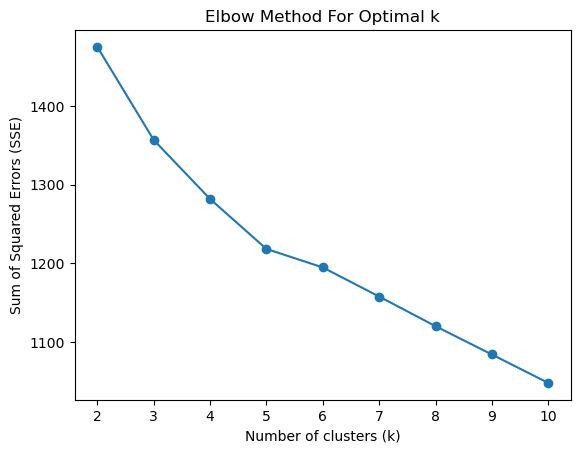

In [3]:
# Function to create train and test datasets using biweekly periods
train_data, test_data = split_train_test_iso(pd_transactions)
print(100*train_data.shape[0]/pd_transactions.shape[0])
# Compute Item Similarity with original exponential decay logic 
item_similarity, items = compute_item_similarity_iso(
    train_data=train_data,
    decay_function=exponential_decay,  # Pass the exponential decay function
    user_col='account_id',
    item_col='sku_id',
    period_col='biweekly_period',
    quantity_col='items_phys_cases',
    alpha=0.7,  # Optional, you can set it as per your need
    group_decay_rate=0.7, #needed when group_col is provided
    within_group_decay_rate=0.9, # needed when group_col is not provided
    group_col=None # Assuming you have a column for grouping items, like 'category'
)
# Now, item_similarity contains the similarity matrix, and items contain the list of SKUs
# Find the Most Similar Past Items
optimal_k, sse_values ,sse_diff_changes= select_k(item_similarity)
print(optimal_k)
item_to_cluster = find_most_similar_items(item_similarity, items, optimal_k)
# You can now plot the SSE values to visualize the elbow point
plt.plot(range(2, 11), sse_values, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method For Optimal k')
plt.show()

In [4]:
# Generate Recommendations
top_k = 5
predicted_baskets, ground_truth_baskets, user_histories = generate_basket_data(train_data, test_data, item_similarity, items, item_to_cluster, user_col='account_id', item_col='sku_id', k=top_k,threshold=0)
# evaluate the model
metrics = evaluate_model_metrics(predicted_baskets, ground_truth_baskets, user_histories, k=top_k, n=5)
# Print the results
for metric_name, score in metrics.items():
    print(f"{metric_name}: {score:.4f}")

Avg Precision@k: 0.1270
Avg Recall@k: 0.0923
Avg F1@k: 0.0902
Avg NDCG@k: 0.1943
Avg PHR@k: 0.5423
Avg Repetition Ratio: 0.2592
Avg Exploration Ratio: 0.7267
Avg Recallrep: 0.0977
Avg Recallexpl: 0.0263
Avg PHRrep: 0.4944
Avg PHRexpl: 0.0710
Avg Precision@k over n: 0.1270


Average Basket Size: 11.0247
25th Percentile: 4.0000
50th Percentile (Median): 8.0000
75th Percentile: 14.0000
maximum Basket Size: 111.0000


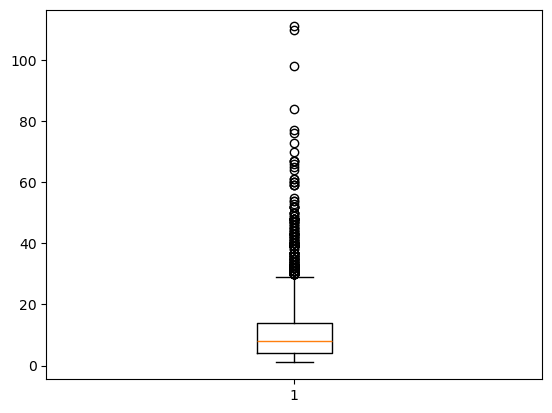

In [5]:
basket_stats = calculate_basket_statistics(ground_truth_baskets)
print(f"Average Basket Size: {basket_stats['average_size']:.4f}")
print(f"25th Percentile: {basket_stats['percentile_25']:.4f}")
print(f"50th Percentile (Median): {basket_stats['percentile_50']:.4f}")
print(f"75th Percentile: {basket_stats['percentile_75']:.4f}")
print(f"maximum Basket Size: {basket_stats['max_size']:.4f}")
plt.boxplot(basket_stats['basket_sizes']);

Average Basket Size: 4.9293
25th Percentile: 5.0000
50th Percentile (Median): 5.0000
75th Percentile: 5.0000
maximum Basket Size: 5.0000


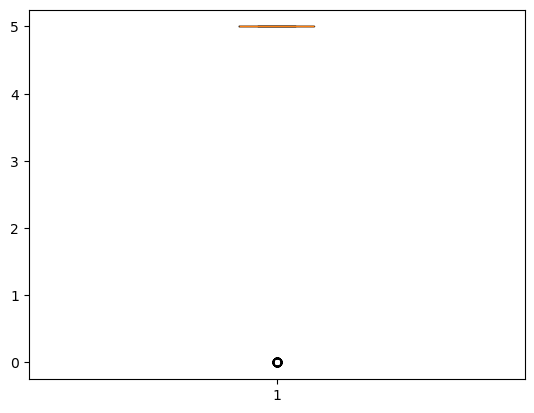

In [6]:
basket_stats = calculate_basket_statistics(predicted_baskets)
print(f"Average Basket Size: {basket_stats['average_size']:.4f}")
print(f"25th Percentile: {basket_stats['percentile_25']:.4f}")
print(f"50th Percentile (Median): {basket_stats['percentile_50']:.4f}")
print(f"75th Percentile: {basket_stats['percentile_75']:.4f}")
print(f"maximum Basket Size: {basket_stats['max_size']:.4f}")
plt.boxplot(basket_stats['basket_sizes']);

In [7]:
# Generate Recommendations
predicted_baskets, ground_truth_baskets, user_histories = generate_basket_data(train_data, test_data, item_similarity, items, item_to_cluster, user_col='account_id', item_col='sku_id', k=top_k,threshold=0.1)
# evaluate the model
metrics = evaluate_model_metrics(predicted_baskets, ground_truth_baskets, user_histories, k=top_k, n=5)
# Print the results
for metric_name, score in metrics.items():
    print(f"{metric_name}: {score:.4f}")

Avg Precision@k: 0.1112
Avg Recall@k: 0.0519
Avg F1@k: 0.0625
Avg NDCG@k: 0.1339
Avg PHR@k: 0.3759
Avg Repetition Ratio: 0.3000
Avg Exploration Ratio: 0.6858
Avg Recallrep: 0.0506
Avg Recallexpl: 0.0263
Avg PHRrep: 0.3257
Avg PHRexpl: 0.0722
Avg Precision@k over n: 0.1112


Average Basket Size: 4.9293
25th Percentile: 5.0000
50th Percentile (Median): 5.0000
75th Percentile: 5.0000
maximum Basket Size: 5.0000


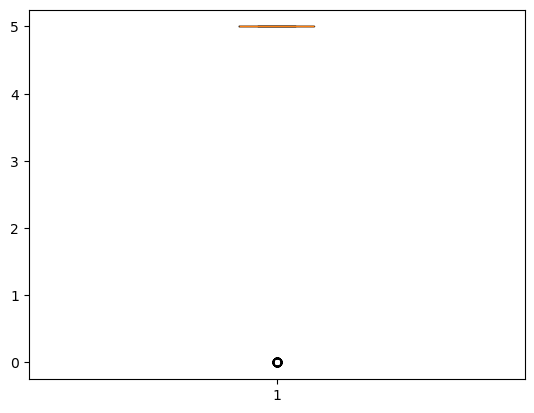

In [8]:
basket_stats = calculate_basket_statistics(predicted_baskets)
print(f"Average Basket Size: {basket_stats['average_size']:.4f}")
print(f"25th Percentile: {basket_stats['percentile_25']:.4f}")
print(f"50th Percentile (Median): {basket_stats['percentile_50']:.4f}")
print(f"75th Percentile: {basket_stats['percentile_75']:.4f}")
print(f"maximum Basket Size: {basket_stats['max_size']:.4f}")
plt.boxplot(basket_stats['basket_sizes']);

In [9]:
# Generate Recommendations
predicted_baskets, ground_truth_baskets, user_histories = generate_basket_data(train_data, test_data, item_similarity, items, item_to_cluster, user_col='account_id', item_col='sku_id', k=top_k,threshold=0.3)
# evaluate the model
metrics = evaluate_model_metrics(predicted_baskets, ground_truth_baskets, user_histories, k=top_k, n=5)
# Print the results
for metric_name, score in metrics.items():
    print(f"{metric_name}: {score:.4f}")

Avg Precision@k: 0.1212
Avg Recall@k: 0.0970
Avg F1@k: 0.0932
Avg NDCG@k: 0.1600
Avg PHR@k: 0.4244
Avg Repetition Ratio: 0.2433
Avg Exploration Ratio: 0.7426
Avg Recallrep: 0.0996
Avg Recallexpl: 0.0268
Avg PHRrep: 0.3765
Avg PHRexpl: 0.0671
Avg Precision@k over n: 0.1212


Average Basket Size: 4.9293
25th Percentile: 5.0000
50th Percentile (Median): 5.0000
75th Percentile: 5.0000
maximum Basket Size: 5.0000


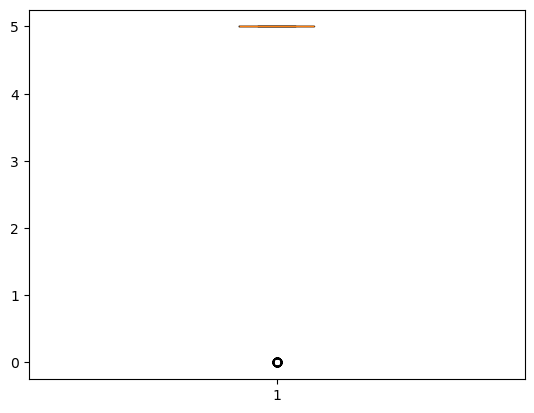

In [10]:
basket_stats = calculate_basket_statistics(predicted_baskets)
print(f"Average Basket Size: {basket_stats['average_size']:.4f}")
print(f"25th Percentile: {basket_stats['percentile_25']:.4f}")
print(f"50th Percentile (Median): {basket_stats['percentile_50']:.4f}")
print(f"75th Percentile: {basket_stats['percentile_75']:.4f}")
print(f"maximum Basket Size: {basket_stats['max_size']:.4f}")
plt.boxplot(basket_stats['basket_sizes']);

In [11]:
# Generate Recommendations
predicted_baskets, ground_truth_baskets, user_histories = generate_basket_data(train_data, test_data, item_similarity, items, item_to_cluster, user_col='account_id', item_col='sku_id', k=top_k,threshold=0.5)
# evaluate the model
metrics = evaluate_model_metrics(predicted_baskets, ground_truth_baskets, user_histories, k=top_k, n=5)
# Print the results
for metric_name, score in metrics.items():
    print(f"{metric_name}: {score:.4f}")

Avg Precision@k: 0.0417
Avg Recall@k: 0.0221
Avg F1@k: 0.0259
Avg NDCG@k: 0.0470
Avg PHR@k: 0.1140
Avg Repetition Ratio: 0.1240
Avg Exploration Ratio: 0.8618
Avg Recallrep: 0.0188
Avg Recallexpl: 0.0121
Avg PHRrep: 0.0911
Avg PHRexpl: 0.0310
Avg Precision@k over n: 0.0417


Average Basket Size: 4.6409
25th Percentile: 5.0000
50th Percentile (Median): 5.0000
75th Percentile: 5.0000
maximum Basket Size: 5.0000


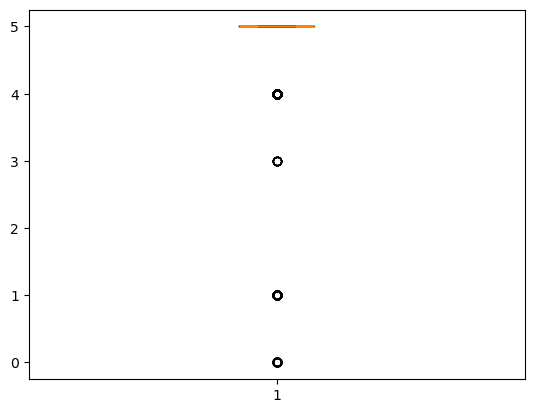

In [12]:
basket_stats = calculate_basket_statistics(predicted_baskets)
print(f"Average Basket Size: {basket_stats['average_size']:.4f}")
print(f"25th Percentile: {basket_stats['percentile_25']:.4f}")
print(f"50th Percentile (Median): {basket_stats['percentile_50']:.4f}")
print(f"75th Percentile: {basket_stats['percentile_75']:.4f}")
print(f"maximum Basket Size: {basket_stats['max_size']:.4f}")
plt.boxplot(basket_stats['basket_sizes']);